EE21S061 Arihant Jain Lab 11 for EE5175 course:

In [1]:
import matlab.engine
import scipy
from sklearn.metrics import mean_squared_error


In [2]:
eng = matlab.engine.start_matlab()

* To use the provided matlab file i am using the matlab engine official provided and supported by matlab.

* I have created a few function which takes numpy array and change them to matlab double and vica-versa to use matlab function wherever needed

In [3]:
def pythontomat(x):
    return matlab.double(x.tolist())

def mattopython(x):
    return np.asarray(x)

In [31]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

plt.rcParams['figure.figsize'] = [18, 7] 

In [5]:
lena=imread("lena.png")

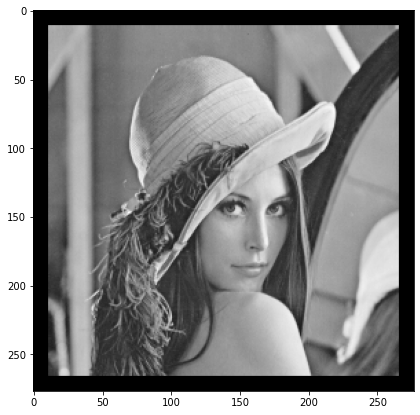

In [6]:
plt.imshow(lena,cmap="gray")

* Importing previously defined function from previous labs to use for building gaussian kernel and also for convolution

In [ ]:
def gaussiankernel(sigma,size):
    
    kernel=np.zeros((size,size))
    #intializing kernel array with zeros
    if size==1:
        #mathematical operation fail for -ve value for sigma so added this check to account for it
        return np.array(([0, 0, 0],[0,1,0],[0, 0, 0]), dtype="int")
    temp=2*(sigma**2)
    d=size//2
    #the function to calculate gaussian value for each cell have certain constant accross them so computing them beforehand
    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(temp))
    kernel=kernel/np.sum(kernel)
    return kernel

def convolution_2d(kernel,img):
    size=kernel.shape[0]
    pad=size//2
    res=np.zeros((img.shape[0],img.shape[1]))
    img=np.pad(img, (pad, pad), 'constant')
    #Zero padding the image to work around edge cases in the image
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            #applying kernel on np array using slicing this allows us to reduce the length of code 
            # as well as use optimization done by numpy
            res[i][j] = (img[i:i+(2*pad)+1,j:j+(2*pad)+1]*kernel).sum()
    return res

def zero_pad_image(image, pad_size):
    x, y = np.shape(image)
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size))
    padded_image[pad_size:-pad_size, pad_size:-pad_size] = image
    return padded_image

def conv_2D(image, kernel, conv_type='same', correlation=True):
    # get the shape of the image
    x, y = np.shape(image)
    # get the shape of the kernel
    # assumed that the kernel is a square matrix
    w = len(kernel)
    d = w//2
    # if the kernel is a single value, simply multiply and return
    if d == 0:
        filtered_image = kernel*image
    else:
        if not correlation:
            # flip the kernel if convolution is to be performed
            kernel = kernel[::-1, ::-1]
        if conv_type == 'valid':
            # no zero padding needed now
            filtered_image = np.zeros((x-2*d, y-2*d))
            for i in range(d, x-d):
                for j in range(d, y-d):
                    # extract image patch
                    patch = image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        elif conv_type == 'same':
            # zero pad so that the output is of the same size
            padded_image = zero_pad_image(image, d)
            filtered_image = np.zeros((x, y))
            for i in range(d, x+d):
                for j in range(d, x+d):
                    # extract image patch
                    patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        else:
            filtered_image = image
    return filtered_image

def PSNR(original_image, distorted_image):
    temp = np.mean((distorted_image-original_image)**2)
    return 20*np.log10(np.max(original_image)/np.sqrt(temp))


# L2 regularized NBD :

f=clean image
h=blur kernel
g=blurred image




$$\hat{f} = argmin_f  {||h*f-g||_2^2 + \lambda (||q_x*f||_2^2 + ||q_y*f||_2^2) }$$

where $ q_x = [1,-1] $ and $ q_y=q_x^T $


By equating the differential to zero we arrive at

$$\hat{f} = (H^TH + \lambda Q_x^TQ_x + \lambda Q_y^T Q_y)^{-1} H^T g)$$



Taking Fourier Transform of the above expression gets us:

$$\hat{f} = IDFT (\frac {H^*}{H^*H + \lambda Q_x^*Q_x + \lambda Q_y^*Q_y} G)$$

This operation is being done using custom function defined as restore_image_L2

In [121]:
def noisyimage(image,sigma_b,sigma_n):
    
    x,y=image.shape
    h=gaussiankernel(sigma_b,3)
    # compute a gaussian kernel based on sigma_b value and convolued it with the image.
    blur_image=convolution_2d(h,image)
    mean=0
    # adding noise with mean 0 and variance as sigma_n^2
    g=blur_image+np.random.normal(mean, sigma_n**2, size=(x, y))
    return g


def restore_image(image,sigma_b,lambda_i):
    
    qx = np.array([1, -1])
    qy = np.array([[1],[-1]])
    # Setting up the gradient operator
    x,y=image.shape
    
    sz=pythontomat(np.array([x, y]))
    # computing size matrix equivalent of matlab to pass in matlab based function calls
    H=np.asarray(eng.psf2otf(sigma_b,sz))

    Qx=np.asarray(eng.psf2otf(matlab.double(qx.tolist()),sz))
    # using psf2otf function as mentioned in the question to compute all the neccessary matrix for the given size image
    Qy=np.asarray(eng.psf2otf(matlab.double(qy.tolist()),sz))
    
    G=np.fft.fft2(image)
    # fft transform of the image
    trans = (np.array(np.matrix(H).getH()) * G) / ((np.abs(H)**2) + (lambda_i*(np.abs(Qx)**2)) + (lambda_i * (np.abs(Qy)**2)) )
    # computing all the transformation to denoise the image in fourier domain
    restored_image = np.abs(np.fft.ifft2(trans))
    # Taking absolute value of the inverse fft2 transform of the computed value
    return restored_image

Given Parameters:

$\sigma_n$ = Gaussian Noise and $\sigma_b$ = Gaussian Blur

* $\sigma_n = 8 $ and $ \sigma_b = [0.5,1.0,1.5] $  


* $\sigma_b  = 1.0 $ and $ \sigma_n = [5,10,15] $

In [14]:
image=lena

# Adding Noise to the original Image 

* First applying a gaussian kernel to the image.
* and then adding random value to the image with normal of sigma_n

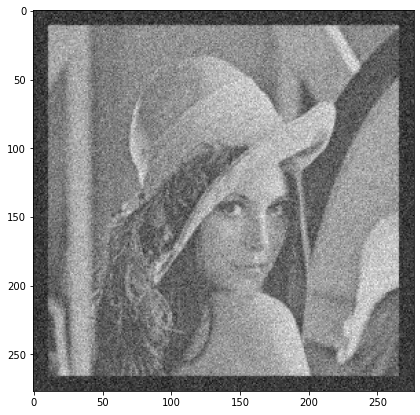

In [55]:
plt.rcParams['figure.figsize'] = [18, 7] 
noisy_image = noisyimage(image,0.5,5)
plt.imshow(noisy_image,cmap='gray')

* We get a degrade image as we can see above

* for $ \sigma_b = 0.5 $ and $ \lambda = 1 $ we get the following clean image

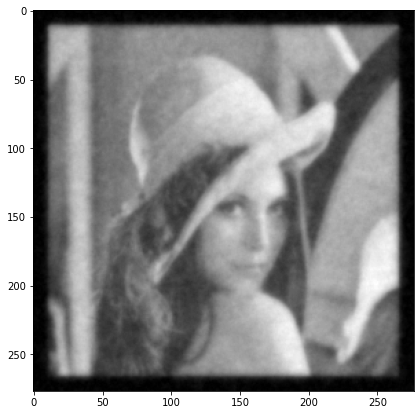

In [56]:
res=restore_image(noisy_image,0.5,1)
plt.imshow(res,cmap='gray')

In [17]:
lambdas = np.arange(0.01,2.01,0.01)

In [152]:
sigma_n = 8

sigma_b = [0.5,1.0,1.5]

best_lambdas = []
err_all_run = []

for j in sigma_b:

    noise_image=noisyimage(image,j,sigma_n)
    
    errs = np.zeros(len(lambdas))
    
    low_err = 0
    
    best_lambda = 0
    
    for i in range(len(lambdas)):
        restored_image = restore_image(noise_image,j,lambdas[i])
        errs[i] = mean_squared_error(noise_image,restored_image)
        if errs[i] < low_err or i == 0:
            low_err = errs[i]
            best_lambda = lambdas[i]
            
    err_all_run.append(errs)
    best_lambdas.append(best_lambda)

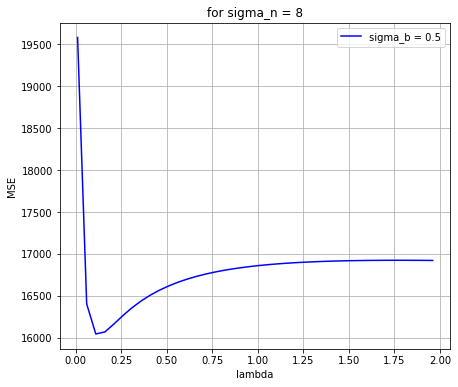

In [153]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_n = 8")
plt.plot(lambdas,err_all_run[0],'blue')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["sigma_b = 0.5"])

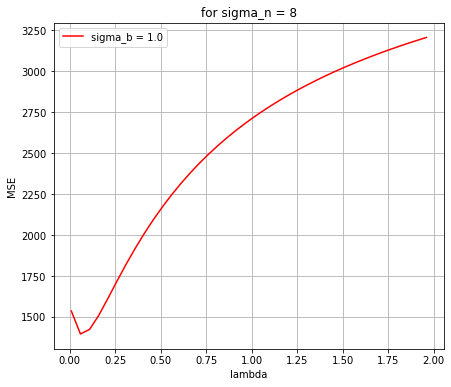

In [154]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_n = 8")
plt.plot(lambdas,err_all_run[1],'red')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["sigma_b = 1.0"])

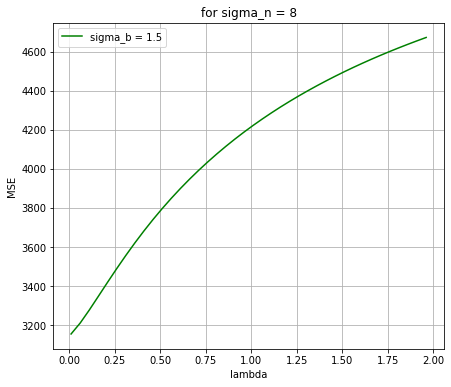

In [155]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_n = 8")
plt.plot(lambdas,err_all_run[2],'green')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["sigma_b = 1.5"])

Text(0.5, 1.0, 'Best Looking Subjectively= 1.2')

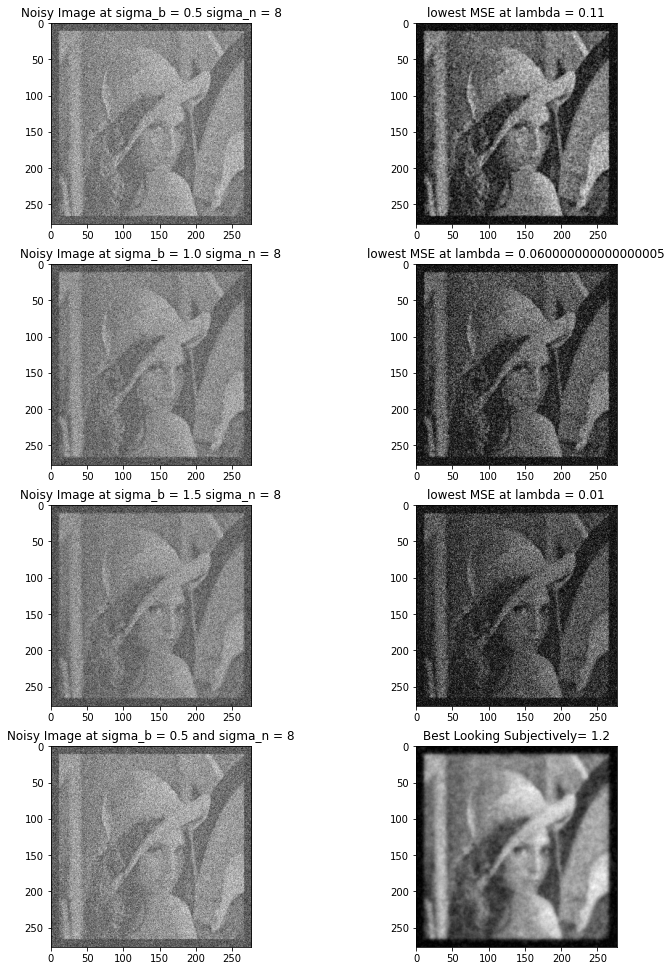

In [156]:
sigma_n = 8
sigma_b = [0.5,1.0,1.5]
plt.rcParams['figure.figsize'] = [12, 17] 
figure, axis = plt.subplots(4,2)
for i in range(3):
    noise_image=noisyimage(image,sigma_b[i],sigma_n)
    axis[i][0].imshow(noise_image,cmap='gray')
    axis[i][0].set_title("Noisy Image at sigma_b = "+ str(sigma_b[i]) + " sigma_n = "+str(sigma_n))
    axis[i][1].imshow(restore_image(noise_image,sigma_b[i],best_lambdas[i]),cmap='gray')
    axis[i][1].set_title("lowest MSE at lambda = "+ str(best_lambdas[i]))
axis[3][0].imshow(noisyimage(image,0.5,sigma_n),cmap='gray')
axis[3][0].set_title("Noisy Image at sigma_b = 0.5 and sigma_n = 8")
axis[3][1].imshow(restore_image(noise_image,0.5,1.2),cmap='gray')
axis[3][1].set_title("Best Looking Subjectively= 1.2")

In [62]:
best_lambdas

[0.13, 0.06999999999999999, 0.01]

# Observations varying $\sigma_b$:

* Increasing lambda is optimum only upto a certain limit beyond which it increase the RMS and leads to diminising return in quality of the image.

* Also we can observe that if the original image is too noisy these only so much the algorithm can do this leads to a recovered image which is not really close to the original image. This shows us the difference between the $f$ and the $\hat{f}$

# Graph:

* Graph shows a similar Story where the MSE first drop drastically before climbing up this gives us a minima really close to 0.01 as we can see above all lowest MSE lambdas are close to starting lambda.

In [63]:
sigma_b = 1.0

sigma_n = [5,10,15]

best_lambdas_2 = []
err_all_run_2 = []

for j in sigma_n:

    noise_image=noisyimage(image,sigma_b,j)
    
    errs = np.zeros(len(lambdas))
    
    low_err = 0
    
    best_lambda = 0
    
    for i in range(len(lambdas)):
        restored_image = restore_image(noise_image,sigma_b,lambdas[i])
        errs[i] = mean_squared_error(noise_image,restored_image)
        if errs[i] < low_err or i == 0:
            low_err = errs[i]
            best_lambda = lambdas[i]
            
    err_all_run_2.append(errs)
    best_lambdas_2.append(best_lambda)

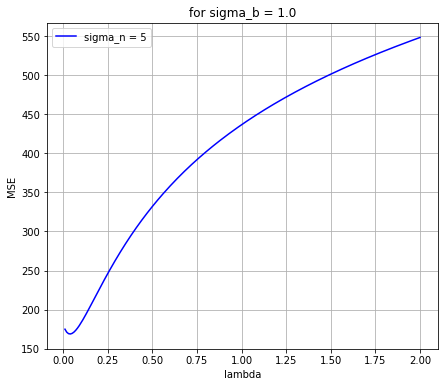

In [64]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.0")
plt.plot(lambdas,err_all_run_2[0],'blue')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["sigma_n = 5"])

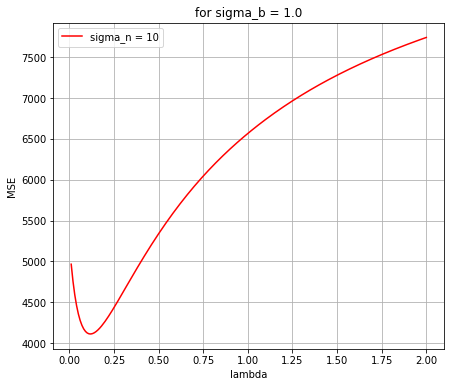

In [65]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.0")
plt.plot(lambdas,err_all_run_2[1],'red')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend([ "sigma_n = 10"])

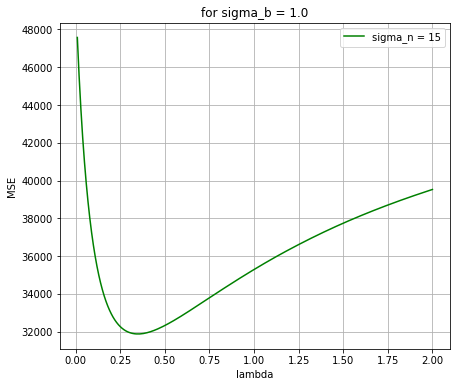

In [66]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.0")
plt.plot(lambdas,err_all_run_2[2],'green')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["sigma_n = 15"])

Text(0.5, 1.0, 'Best Looking Subjectively= 0.8')

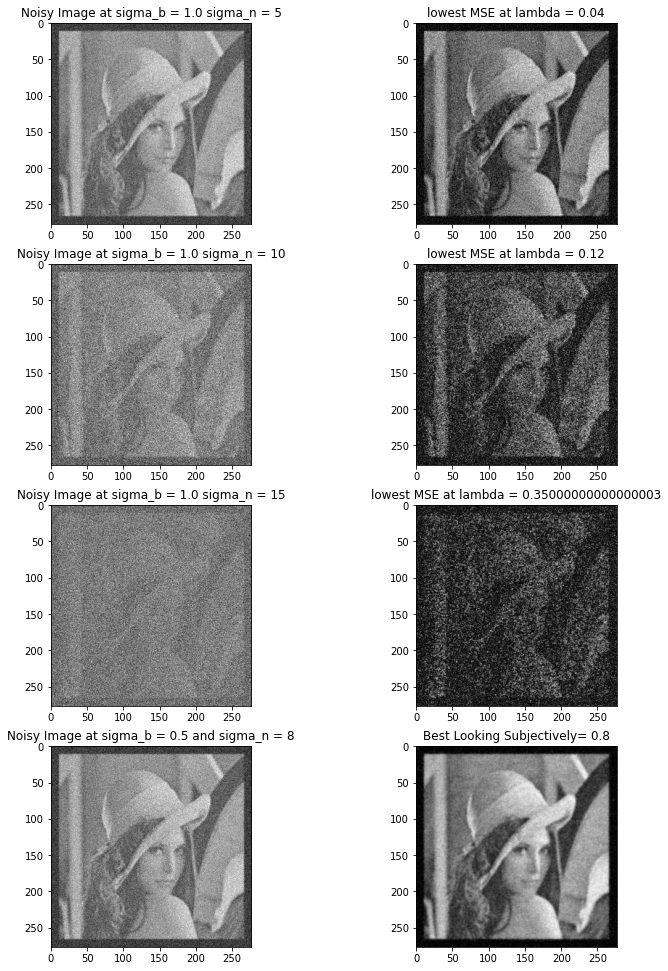

In [129]:
sigma_b = 1.0

sigma_n = [5,10,15]

plt.rcParams['figure.figsize'] = [12, 17] 
figure, axis = plt.subplots(4,2)
for i in range(3):
    noise_image=noisyimage(image,sigma_b,sigma_n[i])
    axis[i][0].imshow(noise_image,cmap='gray')
    axis[i][0].set_title("Noisy Image at sigma_b = "+ str(sigma_b) + " sigma_n = "+str(sigma_n[i]))
    axis[i][1].imshow(restore_image(noise_image,sigma_b,best_lambdas_2[i]),cmap='gray')
    axis[i][1].set_title("lowest MSE at lambda = "+ str(best_lambdas_2[i]))
axis[3][0].imshow(noisyimage(image,1.0,5),cmap='gray')
axis[3][0].set_title("Noisy Image at sigma_b = 0.5 and sigma_n = 8")
axis[3][1].imshow(restore_image(noisyimage(image,1.0,5),1.0,0.8),cmap='gray')
axis[3][1].set_title("Best Looking Subjectively= 0.8")

In [68]:
best_lambdas_2

[0.04, 0.12, 0.35000000000000003]

# Observations varying $\sigma_n$:

* Varying sigma n leads to much more noise in the image which at 15 is too much. we can visualize the noisy image and check for ourselves how noisy the image gets.

* Here the results are similar the algorithm is trying to denoise the image but the solution is very hard to reach which leads to higher RMS scores and a not much recovery in image quality beyond a certain point.

* Best Looking Results results in higher scores but they are visually more appealing image subjectively speaking.

# L2 vs L1 norm regularization

* Here i will be looking to call the matlab file provided in the lab to compute the L1 Norm regularized image.

* In this section we will be comparing the L2 and L1 norm methods for image denoising.

In [101]:
def restore_image_L1(image,sigma_b,lambda_i):
    h=gaussiankernel(sigma_b,3)
    return mattopython(eng.admmfft(pythontomat(image),pythontomat(h),float(lambda_i),1))

In [102]:
lambda_i = 1.5
sigma_b = 1.0
sigma_n = 8
noisy_image=noisyimage(image,sigma_b,sigma_n)
restored_image = restore_image_L1(noisy_image,sigma_b,lambda_i)

Text(0.5, 1.0, 'Restored Image')

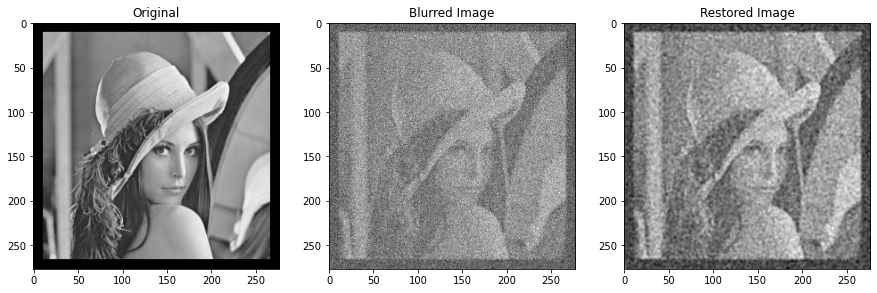

In [103]:
figure, axis = plt.subplots(1,3)

axis[0].imshow(image,cmap='gray')
axis[0].set_title("Original")
axis[1].imshow(noisy_image,cmap='gray')
axis[1].set_title("Blurred Image")
axis[2].imshow(restored_image,cmap='gray')
axis[2].set_title("Restored Image")

* L1 norm function seems to be working but given the quality of the noisy image there's not much the algorithm can recover this results in a bit better but still noisy image as we can see.

In [104]:
best_l1=[]
best_l2=[]

In [105]:
lambdas = np.arange(0.01,2.01,0.05)

errs = np.zeros(len(lambdas))
low_err = 0
best_lambda = 0

sigma_n = 1
sigma_b = 1.5


noise_image=noisyimage(image,sigma_b,sigma_n)    

errs_l1 = np.zeros(len(lambdas))
errs_l2 = np.zeros(len(lambdas))

low_err_l1 = 0
best_lambda_l1 = 0

low_err_l2 = 0
best_lambda_l2 = 0



for i in range(len(lambdas)):
    
    # L1 Regularization
    restored_image = restore_image_L1(noise_image,sigma_b,lambdas[i])
    errs_l1[i] = mean_squared_error(noise_image,restored_image)
    if errs_l1[i] < low_err_l1 or i == 0:
        low_err_l1 = errs_l1[i]
        best_lambda_l1 = lambdas[i]
        
    # L2 Regularization
    
    restored_image = restore_image(noise_image,sigma_b,lambdas[i])
    errs_l2[i] = mean_squared_error(noise_image,restored_image)
    if errs_l2[i] < low_err_l2 or i == 0:
        low_err_l2 = errs_l2[i]
        best_lambda_l2 = lambdas[i]
        
        
best_l1.append(best_lambda_l1)
best_l2.append(best_lambda_l2)

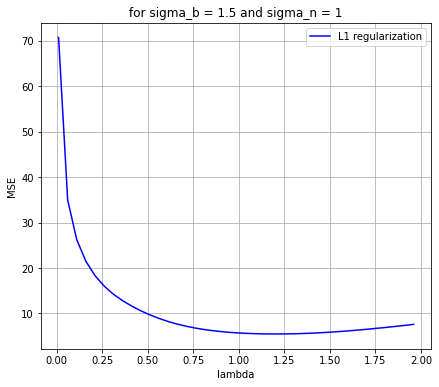

In [106]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 1")
plt.plot(lambdas,errs_l1,'blue')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["L1 regularization"])

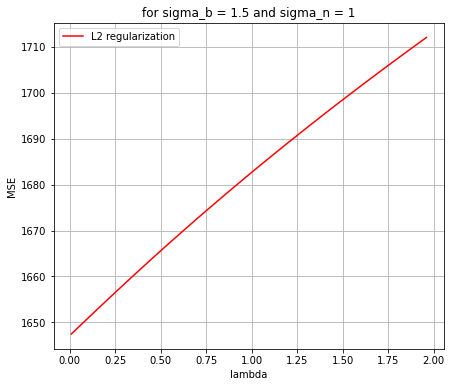

In [107]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 1")
plt.plot(lambdas,errs_l2,'red')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend([ "L2 regularization"])

Text(0.5, 1.0, 'L2 regularization  lambda = 0.01')

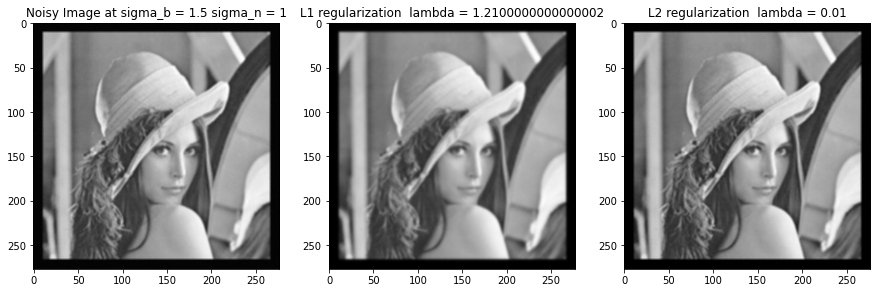

In [117]:
i=0
plt.rcParams['figure.figsize'] = [15, 17] 
figure, axis = plt.subplots(1,3)

sigma_n = 1
sigma_b = 1.5
noise_image=noisyimage(image,sigma_b,sigma_n)
axis[0].imshow(noise_image,cmap='gray')
axis[0].set_title("Noisy Image at sigma_b = "+ str(sigma_b) + " sigma_n = "+str(sigma_n))
axis[1].imshow(restore_image(noise_image,sigma_b,best_l1[i]),cmap='gray')
axis[1].set_title("L1 regularization  lambda = "+ str(best_l1[i]))
axis[2].imshow(restore_image(noise_image,sigma_b,best_l2[i]),cmap='gray')
axis[2].set_title("L2 regularization  lambda = "+ str(best_l2[i]))

# Observation at $\sigma_b = 1.5$ and $\sigma_n = 1$ :

* In this case given the noisy image is not too noisy both the methods leads to a good results.

* We can slightly see how L1 is a bit smoothed than the image from L2 method.

# Graphs:

* For L1 the methods finds a good spot near lambda = 1.21 and we can see how the MSE first falls and then climbs again after a minima

* for L2 the graph for MSE is climbing as we increase the lambda this results in the lowest MSE at 0.01

In [109]:
lambdas = np.arange(0.01,2.01,0.05)

errs = np.zeros(len(lambdas))
low_err = 0
best_lambda = 0

sigma_n = 5
sigma_b = 1.5


noise_image=noisyimage(image,sigma_b,sigma_n)    

errs_l1 = np.zeros(len(lambdas))
errs_l2 = np.zeros(len(lambdas))

low_err_l1 = 0
best_lambda_l1 = 0

low_err_l2 = 0
best_lambda_l2 = 0



for i in range(len(lambdas)):
    
    # L1 Regularization
    restored_image = restore_image_L1(noise_image,sigma_b,lambdas[i])
    errs_l1[i] = mean_squared_error(noise_image,restored_image)
    if errs_l1[i] < low_err_l1 or i == 0:
        low_err_l1 = errs_l1[i]
        best_lambda_l1 = lambdas[i]
        
    # L2 Regularization
    
    restored_image = restore_image(noise_image,sigma_b,lambdas[i])
    errs_l2[i] = mean_squared_error(noise_image,restored_image)
    if errs_l2[i] < low_err_l2 or i == 0:
        low_err_l2 = errs_l2[i]
        best_lambda_l2 = lambdas[i]
        
        
best_l1.append(best_lambda_l1)
best_l2.append(best_lambda_l2)

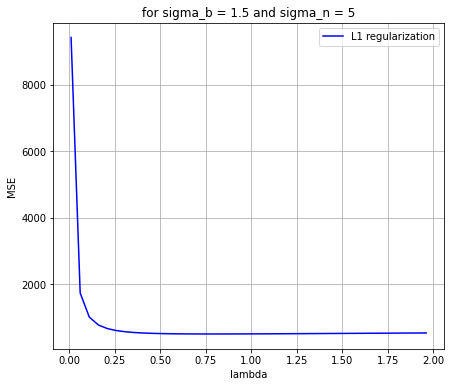

In [110]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 5")
plt.plot(lambdas,errs_l1,'blue')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["L1 regularization"])

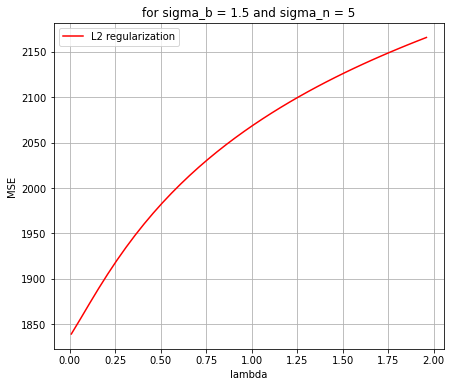

In [111]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 5")
plt.plot(lambdas,errs_l2,'red')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend([ "L2 regularization"])

Text(0.5, 1.0, 'L2 regularization  lambda = 0.01')

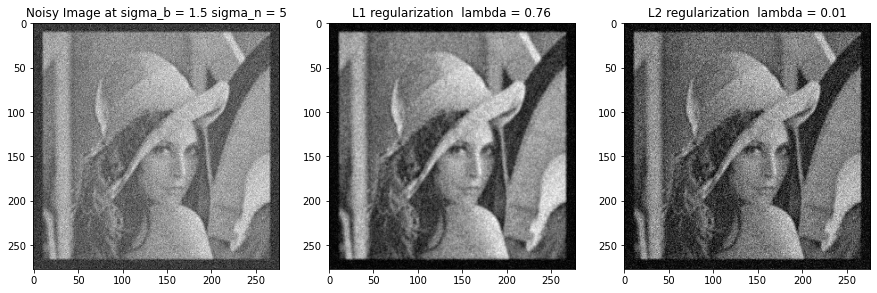

In [112]:
i=1
plt.rcParams['figure.figsize'] = [15, 17] 
figure, axis = plt.subplots(1,3)
noise_image=noisyimage(image,sigma_b,sigma_n)
axis[0].imshow(noise_image,cmap='gray')
axis[0].set_title("Noisy Image at sigma_b = "+ str(sigma_b) + " sigma_n = "+str(sigma_n))
axis[1].imshow(restore_image(noise_image,sigma_b,best_l1[i]),cmap='gray')
axis[1].set_title("L1 regularization  lambda = "+ str(best_l1[i]))
axis[2].imshow(restore_image(noise_image,sigma_b,best_l2[i]),cmap='gray')
axis[2].set_title("L2 regularization  lambda = "+ str(best_l2[i]))

# Observation at $\sigma_b = 1.5$ and $\sigma_n = 5$ :

* Increasing the $\sigma_n$ leads to a much noisy image which can be seen above.
* Here both L1 and L2 struggle but manages to get a good enough recovered image. 
* We can infer more from the graphs.

# Graphs:

* between the previous and current run the difference was only in $\sigma_n$ which means :

* L1 graph drops drastically in the beggining to get a low MSE and then more or less stays.

* Here again the L2 starts climbing up but this time it increases more in the beginning and then starts to decay.

In [168]:
lambdas = np.arange(0.01,2.01,0.05)

errs = np.zeros(len(lambdas))
low_err = 0
best_lambda = 0

sigma_n = 5
sigma_b = 1.5

h=imread("mb-kernel.png")

mean=0
x,y=image.shape
noise_image=conv_2D(image,h,'same') + np.random.normal(mean, sigma_n**2, size=(x, y))


errs_l1 = np.zeros(len(lambdas))
errs_l2 = np.zeros(len(lambdas))

low_err_l1 = 0
best_lambda_l1 = 0

low_err_l2 = 0
best_lambda_l2 = 0

for i in range(len(lambdas)):
    
    # L1 Regularization
    restored_image = mattopython(eng.admmfft(pythontomat(noise_image),pythontomat(h),float(lambdas[i]),1))
    errs_l1[i] = mean_squared_error(noise_image,restored_image)
    if errs_l1[i] < low_err_l1 or i == 0:
        low_err_l1 = errs_l1[i]
        best_lambda_l1 = lambdas[i]
        
    # L2 Regularization
    
    restored_image = restore_image(noise_image,sigma_b,lambdas[i])
    errs_l2[i] = mean_squared_error(noise_image,restored_image)
    if errs_l2[i] < low_err_l2 or i == 0:
        low_err_l2 = errs_l2[i]
        best_lambda_l2 = lambdas[i]
        
        
best_l1.append(best_lambda_l1)
best_l2.append(best_lambda_l2)

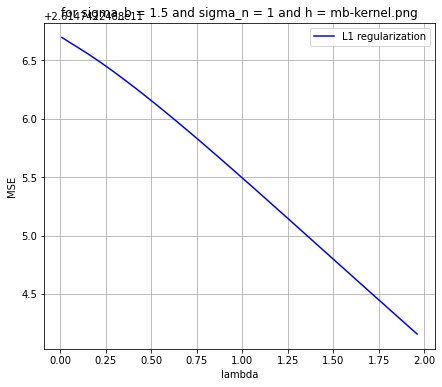

In [169]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 1 and h = mb-kernel.png")
plt.plot(lambdas,errs_l1,'blue')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(["L1 regularization"])

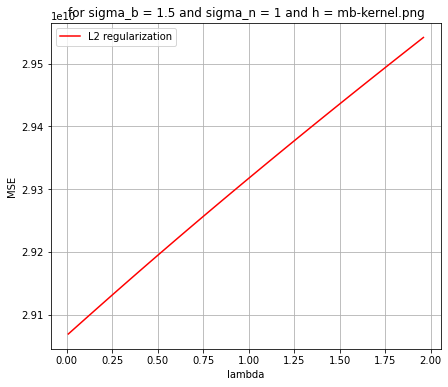

In [170]:
plt.rcParams['figure.figsize'] = [7, 6] 
plt.title("for sigma_b = 1.5 and sigma_n = 1 and h = mb-kernel.png")
plt.plot(lambdas,errs_l2,'red')
plt.grid()
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend([ "L2 regularization"])

Text(0.5, 1.0, 'L2 regularization  lambda = 0.01')

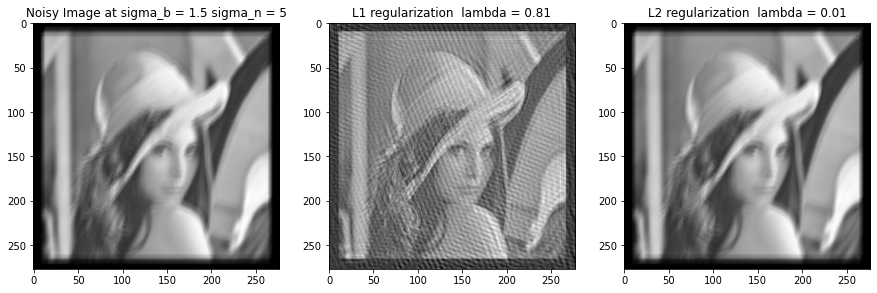

In [172]:
i=2
plt.rcParams['figure.figsize'] = [15, 17] 
figure, axis = plt.subplots(1,3)
h=imread("mb-kernel.png")
mean=0
x,y=image.shape
noise_image=conv_2D(image,h,'same') + np.random.normal(mean, sigma_n**2, size=(x, y))

axis[0].imshow(noise_image,cmap='gray')
axis[0].set_title("Noisy Image at sigma_b = "+ str(sigma_b) + " sigma_n = "+str(sigma_n))
axis[1].imshow(mattopython(eng.admmfft(pythontomat(noise_image),pythontomat(h),float(best_l1[-1]),1)),cmap='gray')
axis[1].set_title("L1 regularization  lambda = "+ str(best_l1[i]))
axis[2].imshow(restore_image(noise_image,sigma_b,best_l2[-1]),cmap='gray')
axis[2].set_title("L2 regularization  lambda = "+ str(best_l2[i]))

# Observation at $\sigma_b = 1.5$ and $\sigma_n = 5$ and kernel for motion blur  :

* For motion blur case we can see how :

* L2 has visible artifact present in the output image which are the result of motion blur kernel applied on the image.

* whereas for L1 the artifact have mostly been taken care of by the L1 regularization method.

# Final Comments:

* L2 regularized deblurring can be done in frequency domain and is much faster than L1 this gives it the advantage in speed but losess in term of performance to L1.